# Water Bottle Shake Sound Classification
## Using Linear SVM with Audio Features

### 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

### 2. Define Feature Extraction Functions

In [2]:
def extract_features(audio_path, sr=44100, n_mfcc=13, n_fft=2048, hop_length=512):
    
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    features = []
    
    # 1. MFCCs (Mel-frequency cepstral coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=128)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    mfccs_max = np.max(mfccs, axis=1)
    mfccs_min = np.min(mfccs, axis=1)
    features.extend(mfccs_mean)
    features.extend(mfccs_std)
    features.extend(mfccs_max)
    features.extend(mfccs_min)
    
    return np.array(features)

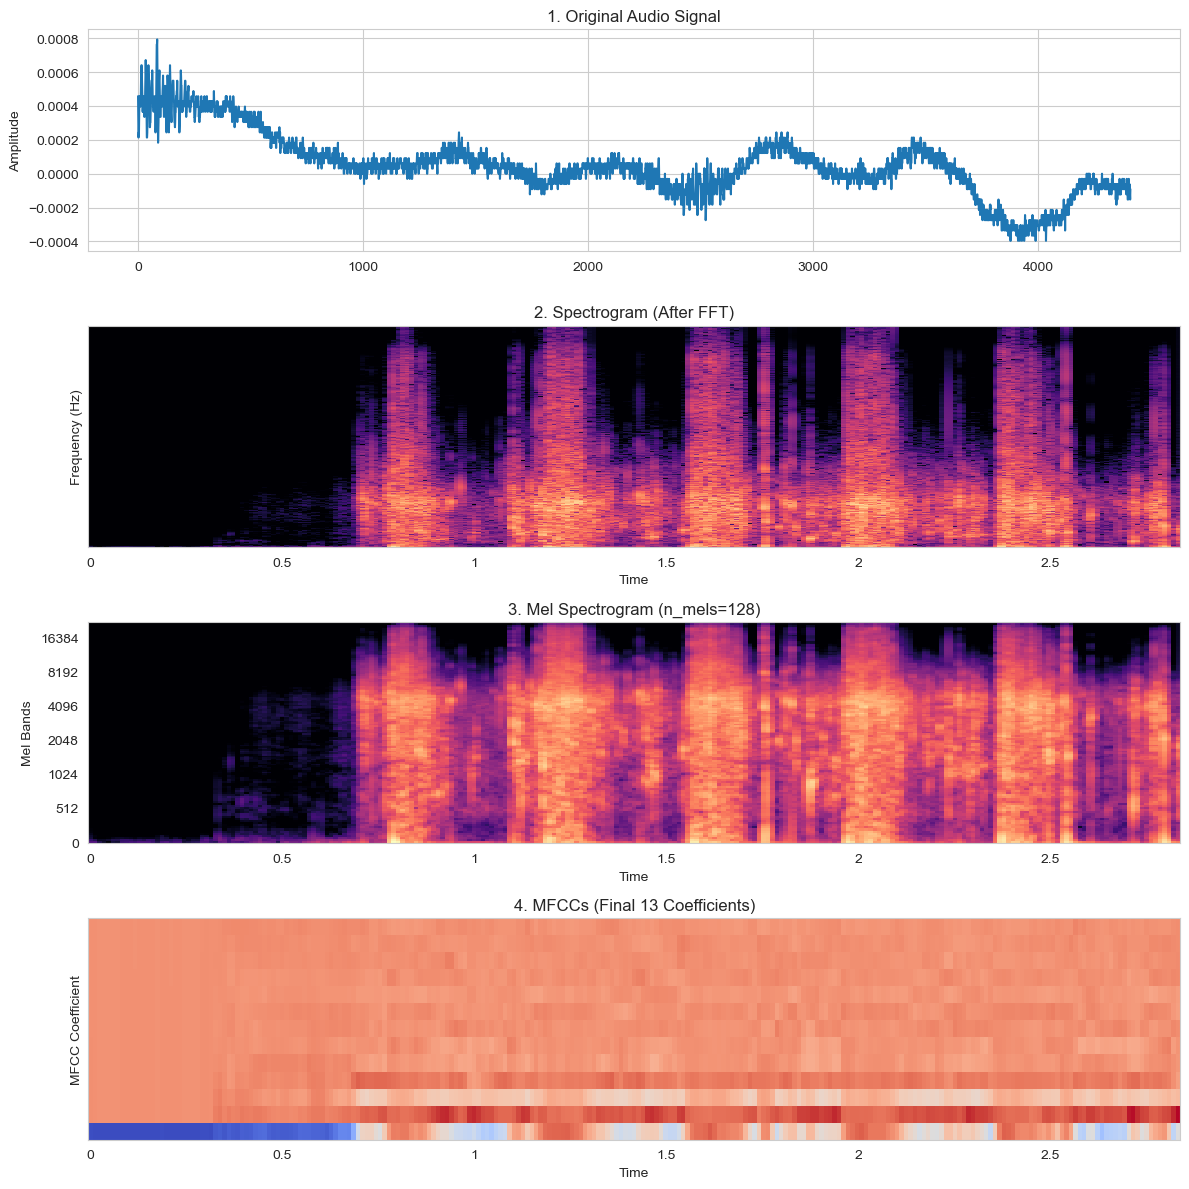

In [158]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Load audio
y, sr = librosa.load('test_quarter_1.wav', sr=44100)

fig, axes = plt.subplots(4, 1, figsize=(12, 12))

# 1. Waveform
axes[0].plot(y[:4410])  # First 0.1 seconds
axes[0].set_title('1. Original Audio Signal')
axes[0].set_ylabel('Amplitude')

# 2. Spectrogram (FFT)
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), 
                         sr=sr, hop_length=512, ax=axes[1], x_axis='time')
axes[1].set_title('2. Spectrogram (After FFT)')
axes[1].set_ylabel('Frequency (Hz)')

# 3. Mel Spectrogram (After Mel Filters)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                         sr=sr, hop_length=512, ax=axes[2], x_axis='time', y_axis='mel')
axes[2].set_title(f'3. Mel Spectrogram (n_mels=128)')
axes[2].set_ylabel('Mel Bands')

# 4. MFCCs (Final)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_mels=128, n_fft=2048, hop_length=512)
librosa.display.specshow(mfccs, sr=sr, hop_length=512, ax=axes[3], x_axis='time')
axes[3].set_title('4. MFCCs (Final 13 Coefficients)')
axes[3].set_ylabel('MFCC Coefficient')

plt.tight_layout()
plt.show()

### 3. Load and Process Data

In [159]:
def load_dataset(data_dir):
    
    classes = ['half_shake', 'quarter_shake', 'three_quarter_shake']
    X = []
    y = []
    file_names = []
    
    print("Extracting features from audio files...")
    
    for class_name in classes:
        print(f"\nProcessing {class_name} files...")
        
        for i in range(1, 11): 
            file_name = f"{class_name}_{i}.wav"
            file_path = os.path.join(data_dir, file_name)
            
            if os.path.exists(file_path):
                try:
                    features = extract_features(file_path)
                    X.append(features)
                    y.append(class_name)
                    file_names.append(file_name)
                    print(f"  ✓ Processed {file_name}")
                except Exception as e:
                    print(f"  ✗ Error processing {file_name}: {e}")
            else:
                print(f"  ✗ File not found: {file_name}")
    
    return np.array(X), np.array(y), file_names

# Load the dataset
data_dir = 'data'  
X, y, file_names = load_dataset(data_dir)

print(f"\n\nDataset loaded successfully!")
print(f"Total samples: {len(X)}")
print(f"Feature vector size: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")
print(f"Samples per class: {dict(zip(*np.unique(y, return_counts=True)))}")

Extracting features from audio files...

Processing half_shake files...
  ✓ Processed half_shake_1.wav
  ✓ Processed half_shake_2.wav
  ✓ Processed half_shake_3.wav
  ✓ Processed half_shake_4.wav
  ✓ Processed half_shake_5.wav
  ✓ Processed half_shake_6.wav
  ✓ Processed half_shake_7.wav
  ✓ Processed half_shake_8.wav
  ✓ Processed half_shake_9.wav
  ✓ Processed half_shake_10.wav

Processing quarter_shake files...
  ✓ Processed quarter_shake_1.wav
  ✓ Processed quarter_shake_2.wav
  ✓ Processed quarter_shake_3.wav
  ✓ Processed quarter_shake_4.wav
  ✓ Processed quarter_shake_5.wav
  ✓ Processed quarter_shake_6.wav
  ✓ Processed quarter_shake_7.wav
  ✓ Processed quarter_shake_8.wav
  ✓ Processed quarter_shake_9.wav
  ✓ Processed quarter_shake_10.wav

Processing three_quarter_shake files...
  ✓ Processed three_quarter_shake_1.wav
  ✓ Processed three_quarter_shake_2.wav
  ✓ Processed three_quarter_shake_3.wav
  ✓ Processed three_quarter_shake_4.wav
  ✓ Processed three_quarter_shake_5.wav


In [24]:
def load_dataset(data_dir):
    
    classes = ['half_shake', 'quarter_shake', 'three_quarter_shake']
    X = []
    y = []
    file_names = []
    
    print("Extracting features from audio files...")
    
    # Get all .wav files in directory
    all_files = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
    
    for class_name in classes:
        print(f"\nProcessing {class_name} files...")
        
        # Find files that start with this class name
        class_files = [f for f in all_files if f.startswith(class_name)]
        
        for file_name in class_files:
            file_path = os.path.join(data_dir, file_name)
            
            try:
                features = extract_features(file_path)
                X.append(features)
                y.append(class_name)
                file_names.append(file_name)
                print(f"  ✓ Processed {file_name}")
            except Exception as e:
                print(f"  ✗ Error processing {file_name}: {e}")
        
        print(f"  Total {class_name}: {len([f for f in file_names if f.startswith(class_name)])}")
    
    return np.array(X), np.array(y), file_names

# Load the dataset
data_dir = 'data'  
X, y, file_names = load_dataset(data_dir)

print(f"\n\nDataset loaded successfully!")
print(f"Total samples: {len(X)}")
print(f"Feature vector size: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")
print(f"Samples per class: {dict(zip(*np.unique(y, return_counts=True)))}")

Extracting features from audio files...

Processing half_shake files...
  ✓ Processed half_shake_20251201_003650.wav
  ✓ Processed half_shake_20251201_003731.wav
  ✓ Processed half_shake_20251201_003645.wav
  ✓ Processed half_shake_20251130_235819.wav
  ✓ Processed half_shake_20251130_235825.wav
  ✓ Processed half_shake_20251130_235830.wav
  ✓ Processed half_shake_20251201_003726.wav
  ✓ Processed half_shake_20251201_003656.wav
  ✓ Processed half_shake_20251201_003736.wav
  ✓ Processed half_shake_20251130_235808.wav
  ✓ Processed half_shake_20251201_003721.wav
  ✓ Processed half_shake_20251130_235716.wav
  ✓ Processed half_shake_20251201_003800.wav
  ✓ Processed half_shake_20251130_235701.wav
  ✓ Processed half_shake_20251201_003817.wav
  ✓ Processed half_shake_20251130_235649.wav
  ✓ Processed half_shake_20251201_003750.wav
  ✓ Processed half_shake_20251201_003745.wav
  ✓ Processed half_shake_20251201_003812.wav
  ✓ Processed half_shake_20251130_235738.wav
  ✓ Processed half_shake_202

In [25]:
X.shape, y.shape
print(X[0].shape)

(52,)


### 4. Prepare Data for Training

In [26]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)  # For visualization

print(f"Training set size: {X_train_scaled.shape[0]} samples")
print(f"Test set size: {X_test_scaled.shape[0]} samples")
print(f"Number of features: {X_train_scaled.shape[1]}")

Training set size: 102 samples
Test set size: 26 samples
Number of features: 52


### 5. Train Linear SVM Model

In [28]:
# Create and train Linear SVM
print("Training Linear SVM...")
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = svm_model.score(X_train_scaled, y_train)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Cross-validation for more robust evaluation
cv_scores = cross_val_score(svm_model, X_scaled, y_encoded, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Training Linear SVM...

Training Accuracy: 1.0000
Test Accuracy: 0.7692

Cross-validation scores: [0.84615385 0.73076923 0.84615385 0.68       0.84      ]
Mean CV accuracy: 0.7886 (+/- 0.1397)


In [29]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
svm_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Evaluate
print(f"Test Accuracy: {svm_model.score(X_test_scaled, y_test):.4f}")

# ========== SAVE MODELS ==========
import joblib
os.makedirs('models', exist_ok=True)

joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

print("\nModels saved to ./models/")

Test Accuracy: 0.7692

Models saved to ./models/


### 6. Model Evaluation


Classification Report:
                     precision    recall  f1-score   support

         half_shake       0.78      0.70      0.74        10
      quarter_shake       1.00      0.75      0.86         8
three_quarter_shake       0.64      0.88      0.74         8

           accuracy                           0.77        26
          macro avg       0.80      0.78      0.78        26
       weighted avg       0.80      0.77      0.77        26



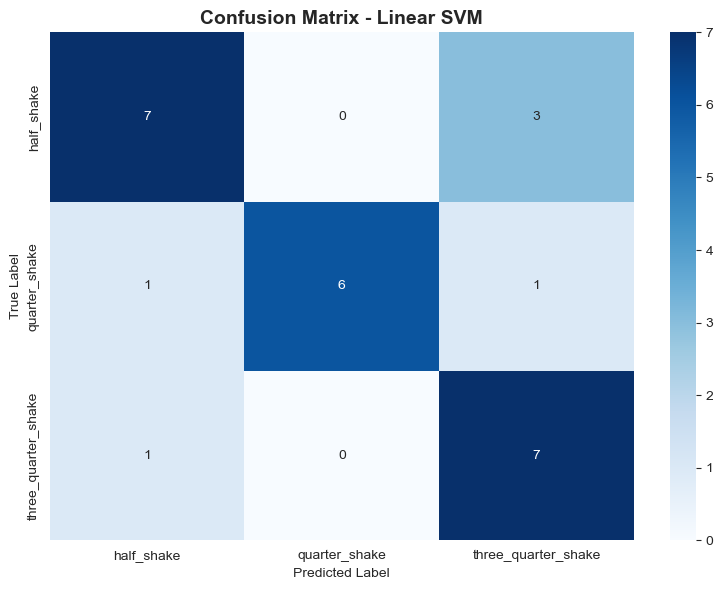

In [30]:
# Classification report
print("\nClassification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Linear SVM', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 7. t-SNE Visualization

Computing t-SNE embedding...
This may take a moment...


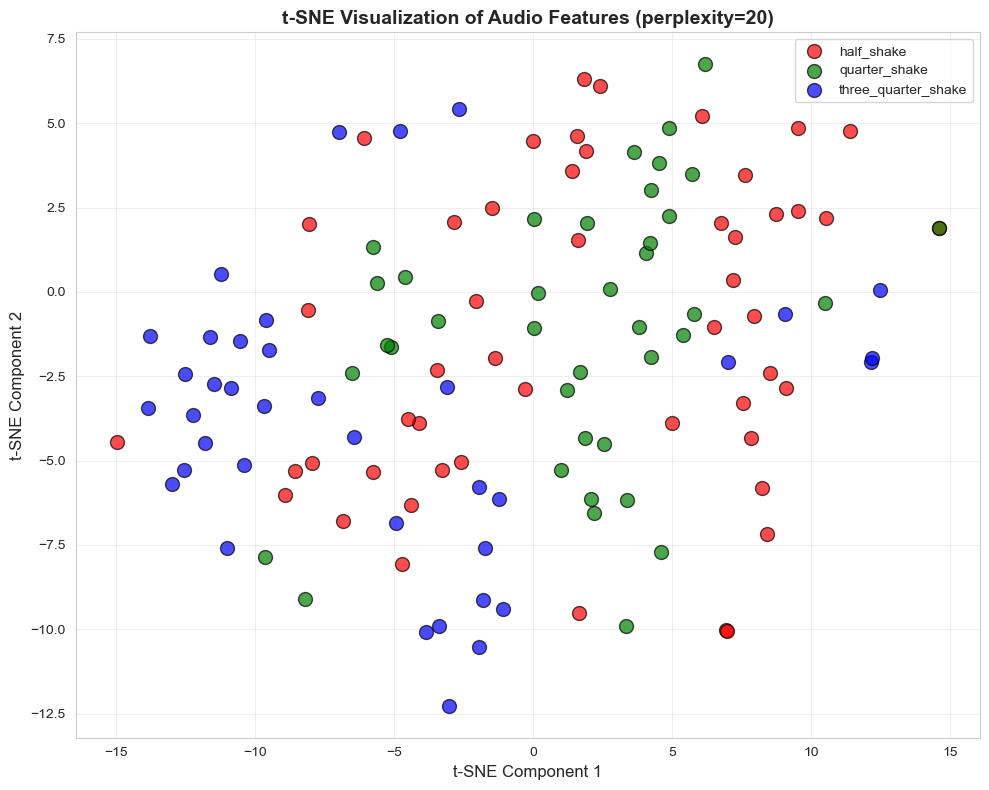


t-SNE visualization complete!


In [32]:
# Apply t-SNE for dimensionality reduction
print("Computing t-SNE embedding...")
print("This may take a moment...")

# Single t-SNE plot
perplexity = 20
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, 
            n_iter=1000, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

# Create single plot
plt.figure(figsize=(10, 8))

# Create color map
colors = ['red', 'green', 'blue']

for i, class_name in enumerate(le.classes_):
    mask = y == class_name
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
              c=colors[i], label=class_name, s=100, alpha=0.7, edgecolors='black')

plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title(f't-SNE Visualization of Audio Features (perplexity={perplexity})', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nt-SNE visualization complete!")

### 9. Predict on New Samples

In [166]:
def predict_single_file(file_path, model, scaler, label_encoder):
    
    # Extract features
    features = extract_features(file_path)
    features_scaled = scaler.transform(features.reshape(1, -1))
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    prediction_proba = model.predict_proba(features_scaled)[0]
    
    # Get class name
    predicted_class = label_encoder.inverse_transform([prediction])[0]
    
    # Create probability dictionary
    probabilities = {}
    for i, class_name in enumerate(label_encoder.classes_):
        probabilities[class_name] = prediction_proba[i]
    
    return predicted_class, probabilities


test_file = 'test_half.wav'
prediction, probs = predict_single_file(test_file, svm_model, scaler, le)
print(f"Predicted class: {prediction}")
print(f"Probabilities: {probs}")

test_file = 'test_quarter_1.wav'
prediction, probs = predict_single_file(test_file, svm_model, scaler, le)
print(f"Predicted class: {prediction}")
print(f"Probabilities: {probs}")

test_file = 'test_quarter_2.wav'
prediction, probs = predict_single_file(test_file, svm_model, scaler, le)
print(f"Predicted class: {prediction}")
print(f"Probabilities: {probs}")





Predicted class: half_shake
Probabilities: {'half_shake': 0.5872905353644751, 'quarter_shake': 0.1147953304022529, 'three_quarter_shake': 0.297914134233272}
Predicted class: quarter_shake
Probabilities: {'half_shake': 0.2211326402577951, 'quarter_shake': 0.6128229720098264, 'three_quarter_shake': 0.1660443877323784}
Predicted class: quarter_shake
Probabilities: {'half_shake': 0.3812074760145481, 'quarter_shake': 0.4370639886187619, 'three_quarter_shake': 0.18172853536668987}
